<a href="https://colab.research.google.com/github/Mahrokh-Eb/Deep-Learning-with-Python/blob/main/1-Image%20Classification%20(cats%20VS%20dogs)/seedPlant/plantSeeding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/plantSeed

/content/drive/MyDrive/plantSeed


In [5]:
%ls

drive/   model_utils.py      plantSeeding-v2.ipynb  __pycache__/  utils.py
kaggle/  plantSeeding.ipynb  predict_utils.py       train.py      vis_utils.py


In [6]:
pwd

'/content/drive/MyDrive/plantSeed'

In [9]:
!pip3 install bcolz 

     |████████████████████████████████| 1.5 MB 37.6 MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp37-cp37m-linux_x86_64.whl size=2641311 sha256=260c72421a55a6bea47587cc9660dd9b39766321550bace0f971e0767c302e27
  Stored in directory: /root/.cache/pip/wheels/2c/35/ca/9d914de345914e2446ea285170329f771b8abba2a00f7650bd
Successfully built bcolz


In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

#Kaggle

In [11]:
#pip install kaggle

In [12]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/plantSeed/drive"

In [13]:
#Change your present working directory
%cd /content/drive/MyDrive/plantSeed/drive

/content/drive/MyDrive/plantSeed/drive


In [14]:
pwd

'/content/drive/My Drive/plantSeed/drive'

## download dataset from kaggle

In [15]:
'''	!pip uninstall -y kaggle
  !pip install --upgrade pip
  !pip install kaggle==1.5.6'''

'\t!pip uninstall -y kaggle\n  !pip install --upgrade pip\n  !pip install kaggle==1.5.6'

In [16]:
#copy API from dataset section in kaggle website
#!kaggle competitions download -c plant-seedlings-classification

In [17]:
!ls

kaggle.json  sample_submission.csv  test  train  valid


In [18]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

In [19]:
!ls

kaggle.json  sample_submission.csv  test  train  valid


In [113]:
DATA_DIR ='/content/drive/MyDrive/plantSeed/drive/'

sz = 224
batch_size = 16

In [92]:
os.listdir(DATA_DIR)

['sample_submission.csv',
 'kaggle.json',
 'test',
 'train',
 'valid',
 '.ipynb_checkpoints']

In [93]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [94]:
trn_fnames = glob.glob(f'{trn_dir}/*/*')
trn_fnames[:5]

['/content/drive/MyDrive/plantSeed/drive/train/Black-grass/0050f38b3.png',
 '/content/drive/MyDrive/plantSeed/drive/train/Black-grass/0183fdf68.png',
 '/content/drive/MyDrive/plantSeed/drive/train/Black-grass/0260cffa8.png',
 '/content/drive/MyDrive/plantSeed/drive/train/Black-grass/05eedce4d.png',
 '/content/drive/MyDrive/plantSeed/drive/train/Black-grass/082314602.png']

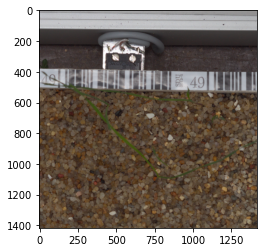

In [95]:
img = plt.imread(trn_fnames[16])
plt.imshow(img);

# Datasets and Dataloaders in PyTorch

- Dataset
A set of images.
- Dataloader
Loads data from dataset behind the scene using concurrent threads.

In [96]:
train_ds = datasets.ImageFolder(trn_dir)

In [97]:
train_ds.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [98]:
train_ds.class_to_idx

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

# create validation data

In [99]:
# use it after generating your model
'''import keras
from keras.models import Sequential
valid_set = [( )]
model.fit(x=train_ds, y=None, batch_size=None, epochs=1, verbose='auto', callbacks=None, validation_split=0.1, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_batch_size=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)'''

"import keras\nfrom keras.models import Sequential\nvalid_set = [( )]\nmodel.fit(x=train_ds, y=None, batch_size=None, epochs=1, verbose='auto', callbacks=None, validation_split=0.1, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_batch_size=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)"

In [100]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
#valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [101]:
len(train_ds)

4750

## Dataloaders

In [102]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)
#valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


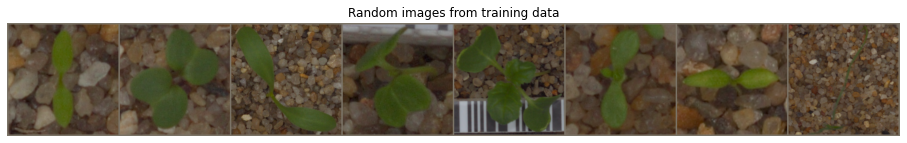

In [103]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

# Model: CNN

In [119]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        '''self.conv3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )'''
        
        self.fc = nn.Linear(56 * 56 * 32, 12)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        #out = self.conv3(out)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = self.fc(out)
        return out

In [120]:
model = SimpleCNN()

# transfer model to GPU
if use_gpu:
    model = model.cuda()

## Loss function and optimizer

In [121]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

## Train

In [122]:
num_epochs = 2
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = to_var(inputs)
        targets = to_var(targets)
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses += [loss.data]
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.data))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [ 1/ 2], Step [ 50/296], Loss: 2.2685
Epoch [ 1/ 2], Step [100/296], Loss: 2.1422
Epoch [ 1/ 2], Step [150/296], Loss: 2.2266
Epoch [ 1/ 2], Step [200/296], Loss: 2.4418
Epoch [ 1/ 2], Step [250/296], Loss: 2.1004
Epoch [ 1/ 2], Step [300/296], Loss: 1.7780
Epoch [ 1/ 2], Step [350/296], Loss: 1.5827
Epoch [ 1/ 2], Step [400/296], Loss: 2.5118
Epoch [ 1/ 2], Step [450/296], Loss: 2.2420
Epoch [ 1/ 2], Step [500/296], Loss: 2.7162
Epoch [ 1/ 2], Step [550/296], Loss: 1.8255
Epoch [ 2/ 2], Step [ 50/296], Loss: 2.3090
Epoch [ 2/ 2], Step [100/296], Loss: 1.3569
Epoch [ 2/ 2], Step [150/296], Loss: 1.0266
Epoch [ 2/ 2], Step [200/296], Loss: 2.1625
Epoch [ 2/ 2], Step [250/296], Loss: 1.6737
Epoch [ 2/ 2], Step [300/296], Loss: 2.3486
Epoch [ 2/ 2], Step [350/296], Loss: 1.5118
Epoch [ 2/ 2], Step [400/296], Loss: 0.7964
Epoch [ 2/ 2], Step [450/296], Loss: 1.5563
Epoch [ 2/ 2], Step [500/296], Loss: 1.7998
Epoch [ 2/ 2], Step [550/296], Loss: 1.2387


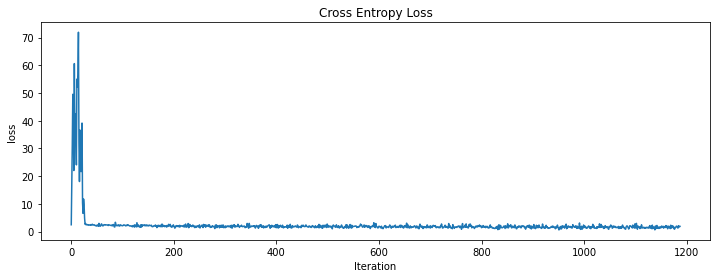

In [123]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');

### Analyze results

In [124]:
def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [125]:
evaluate_model(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/My Drive/plantSeed/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 54.27


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/My Drive/plantSeed/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


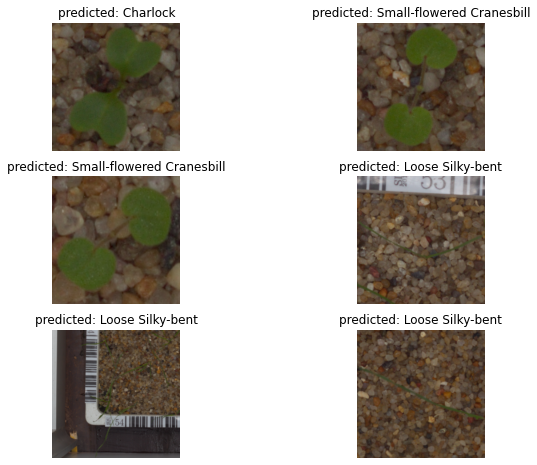

In [126]:
visualize_model(model, train_dl)

# confusion matrix

  0%|          | 0/594 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/My Drive/plantSeed/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
100%|██████████| 594/594 [01:02<00:00,  9.55it/s]


[[0.         0.         0.         0.         0.         0.00760456
  0.97718631 0.00380228 0.00380228 0.         0.         0.00760456]
 [0.         0.48974359 0.03076923 0.01794872 0.         0.05384615
  0.08974359 0.02820513 0.13846154 0.03589744 0.04615385 0.06923077]
 [0.         0.08013937 0.16724739 0.0174216  0.         0.08013937
  0.40766551 0.00348432 0.10452962 0.02439024 0.07665505 0.03832753]
 [0.         0.00818331 0.00163666 0.80851064 0.         0.01309329
  0.00818331 0.07201309 0.0294599  0.0294599  0.01963993 0.00981997]
 [0.         0.03167421 0.         0.00452489 0.         0.01809955
  0.87782805 0.00904977 0.0361991  0.         0.         0.02262443]
 [0.         0.00631579 0.01263158 0.03789474 0.         0.38736842
  0.50315789 0.         0.00421053 0.00421053 0.04       0.00421053]
 [0.         0.00152905 0.00152905 0.0030581  0.         0.00611621
  0.96636086 0.00152905 0.00611621 0.00152905 0.0030581  0.00917431]
 [0.         0.01809955 0.00904977 0.3303

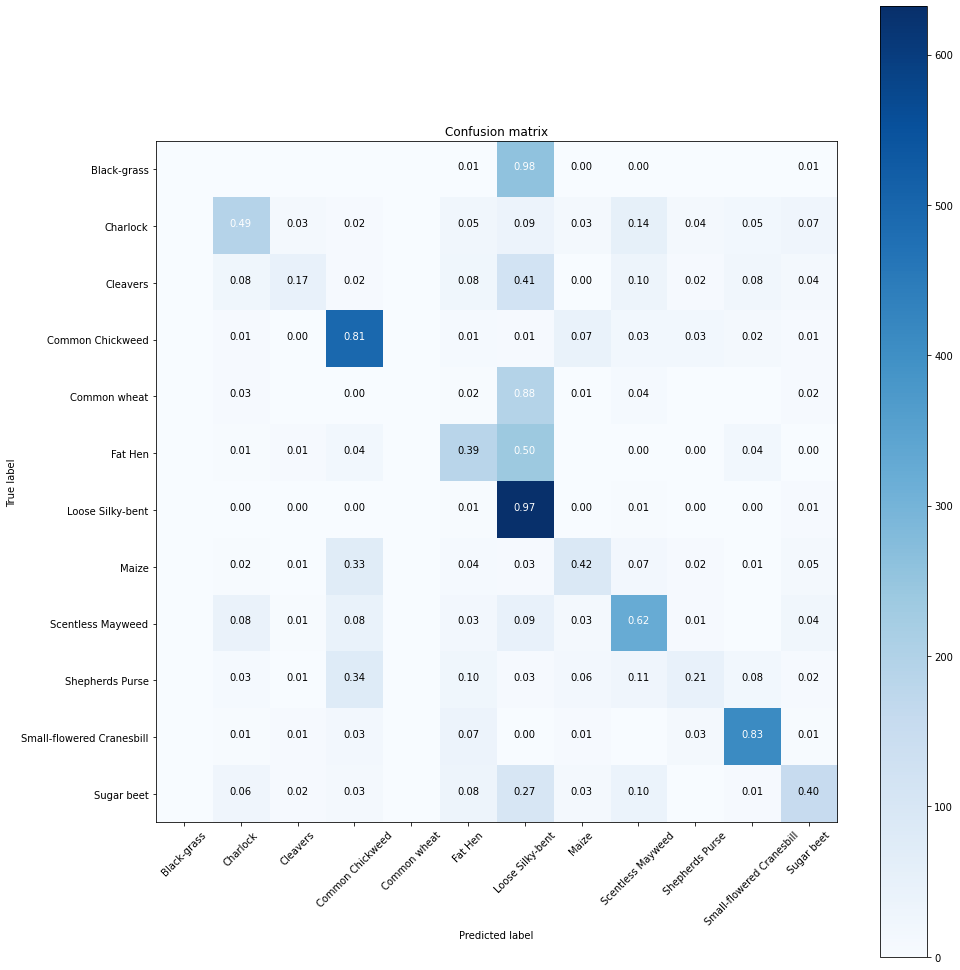

In [128]:
y_pred, y_true = predict_class(model, train_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(14, 14))